In [ ]:
# popular trips: 1) mornings between x hours on Mon-Fri 2) evenings between x hours on Mon-Fri 3) trips between 5 & 20 mins on Mon-Fri 4-5) trips between 5-20 mins from common start and end station during commuting
# offers: discounts for using bikes at stations with high availability, discounts for subscription types during popular commute times

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [135]:
%matplotlib inline

# What are the 5 most popular trips that you would call "commuter trips"?

## 1 & 2) Morning Trips Between 7-10am & Evening Trips Between 4-7pm (Mon-Fri)

In [28]:
%%bigquery pop_trip_times_df

SELECT 
    EXTRACT(HOUR FROM start_date) AS Hour,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(2, 3, 4, 5, 6)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 24/24 [00:01<00:00, 22.99rows/s]


Text(0.5, 1.0, 'Mon-Fri Commuting')

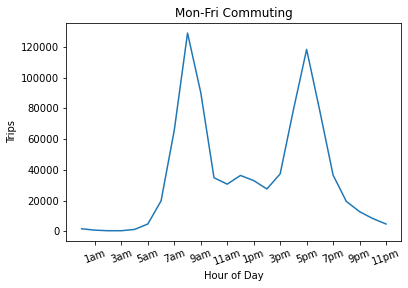

In [137]:
# plot trips by hour

plt.plot(pop_trip_times_df["Hour"], pop_trip_times_df["Trips"])
plt.xlabel("Hour of Day")
plt.ylabel("Trips")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], ["1am", "3am","5am", "7am", "9am", "11am", "1pm", "3pm","5pm", "7pm", "9pm", "11pm"], rotation=20)
plt.title("Mon-Fri Commuting")

The weekday (M-F) trips cluster in around 3 hour periods in the morning (7-10am) and evening (4-7pm). Therefore we will consider these the morning and evening weekday commute trips as they align with the data and our knowledge that most weekday commuting includes a morning and evening commute.

### Morning Commute Trips

In [198]:
%%bigquery morning_commute_df
SELECT 
    Hour,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(2, 3, 4, 5, 6) AND Hour IN(7, 8, 9)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 3/3 [00:00<00:00,  3.11rows/s]


### Evening Commute Trips

In [ ]:
%%bigquery evening_commute_df
SELECT 
    Hour,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(2, 3, 4, 5, 6) AND Hour IN(16, 17, 18)
GROUP BY 1
ORDER BY 1 ASC

## 3) Trips Between 5-20 Mins Mon-Fri During "Non-Busy" Hours

### Spread of commute durations

In [154]:
%%bigquery test_df

SELECT
        trip_id,
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        (duration_sec / 60) AS Mins
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE EXTRACT(DAYOFWEEK FROM start_date) IN(2, 3, 4, 5, 6) AND EXTRACT(HOUR FROM start_date) IN(7, 8, 9, 16, 17, 18)
    ORDER BY 4 ASC

Downloading: 100%|██████████| 560683/560683 [00:01<00:00, 369065.95rows/s]


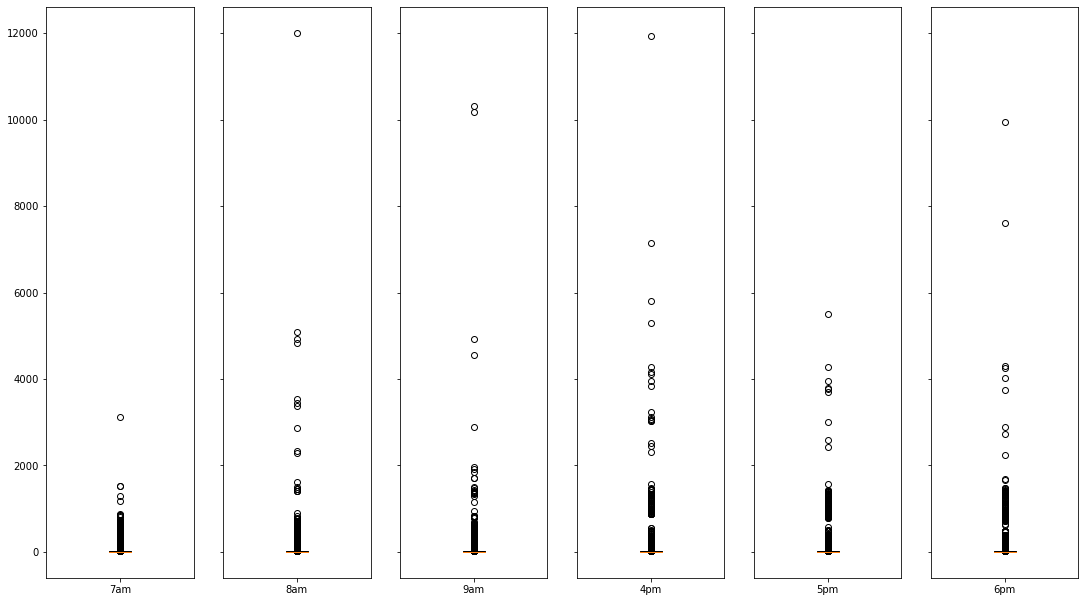

In [155]:
## plot commute duration spread

commute_times = [7, 8, 9, 16, 17, 18]
commute_labels = ["7am", '8am', "9am", "4pm", '5pm', "6pm"]
fig, ax = plt.subplots(ncols=6, sharey=True)
fig.set_size_inches(18.5, 10.5)

for time in commute_times:
    df = test_df[test_df["Hour"] == time]
    ax[commute_times.index(time)].boxplot(df["Mins"])
    ax[commute_times.index(time)].set_xticklabels([commute_labels[commute_times.index(time)]])

The spread of trip duration for all hours of the day are heavily skewed by outliers. We will limit the trip durations to include only those that fall between 5-40 mins as a majority of the distribution (+75%) falls between this range.

## Spread of commute durations adjusted for outliers

In [156]:
%%bigquery validate_df

SELECT
        trip_id,
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        (duration_sec / 60) AS Mins
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE EXTRACT(DAYOFWEEK FROM start_date) IN(2, 3, 4, 5, 6) AND EXTRACT(HOUR FROM start_date) IN(7, 8, 9, 16, 17, 18) AND (duration_sec / 60) < 40 AND duration_sec > 300
    ORDER BY 4 ASC

Downloading: 100%|██████████| 455318/455318 [00:01<00:00, 336451.80rows/s]


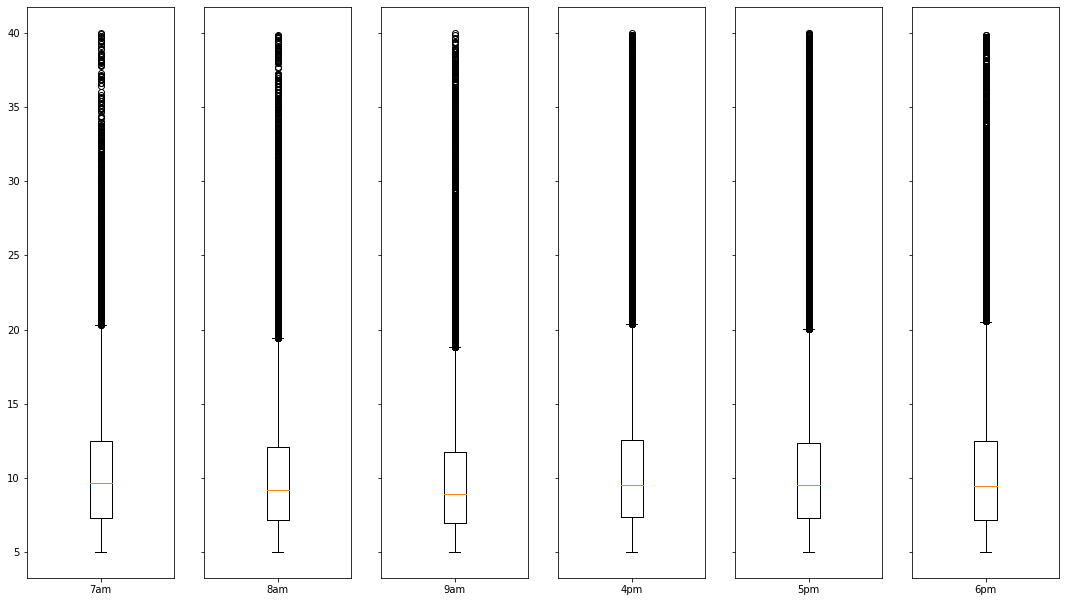

In [157]:
## plot spread of commute hours for trips between 5-40 mins

commute_times = [7, 8, 9, 16, 17, 18]
commute_labels = ["7am", '8am', "9am", "4pm", '5pm', "6pm"]
fig, ax = plt.subplots(ncols=6, sharey=True)
fig.set_size_inches(18.5, 10.5)
i = 0

for time in commute_times:
    df = validate_df[validate_df["Hour"] == time]
    ax[i].boxplot(df["Mins"])
    ax[i].set_xticklabels([commute_labels[i]])
    i += 1

After adjusting for outliers by limiting our time range, we can see that a majority of the morning and evening commute times fall between 5-20 mins. Therefore, we will consider the 3rd popular commute trip to be all trips that fall between 5-20 mins on weekdays to include those who don't commute druing the "busy" hours.

### Weekday Commuting Trips During "Non-Busy" Hours

In [160]:
%%bigquery commutes_in_timerange_df

SELECT
    EXTRACT(DAYOFWEEK FROM start_date) AS Day,
    COUNT(trip_id) AS Trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK FROM start_date) IN(2, 3, 4, 5, 6) AND (duration_sec / 60) <= 20 AND (duration_sec / 60) >= 5 AND EXTRACT(HOUR FROM start_date) NOT IN(7, 8, 9, 16, 17, 18)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.75rows/s]


## 4) 5-20 Minute Weekend (Sat-Sun) Trips From the 5 Most Popular Stations

### Popular Evening Start Stations

In [166]:
%%bigquery pop_start_stations_df

SELECT 
    start_station_id AS ID,
    start_station_name AS Name,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_station_id,
        start_station_name,
        start_date,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
    WHERE EXTRACT(HOUR FROM start_date) IN (16, 17, 18) AND EXTRACT(DAYOFWEEK FROM start_date) IN(2, 3, 4, 5, 6)
GROUP BY 1, 2
ORDER BY 3 DESC
LIMIT 20

Downloading: 100%|██████████| 20/20 [00:01<00:00, 15.75rows/s]


Text(0.5, 1.0, 'Popular Start Stations During Evening Commute')

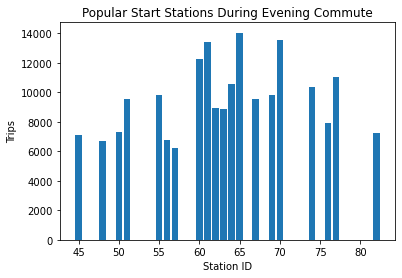

In [168]:
# plot popular start stations

plt.bar(pop_start_stations_df["ID"], pop_start_stations_df["Trips"])
plt.xlabel("Station ID")
plt.ylabel("Trips")
plt.title("Popular Start Stations During Evening Commute")

There are 5 evening stations that stand above the rest: 60, 61, 65, 70, and 77.

### Weekend Commutes from Popular Evening Start Stations

In [177]:
%%bigquery start_station_commutes_df

SELECT
    EXTRACT(DAYOFWEEK FROM start_date) AS Day,
    COUNT(trip_id) AS Trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id IN(60, 61, 65, 70, 77) AND (duration_sec / 60) <= 20 AND (duration_sec / 60) >= 5 AND EXTRACT(DAYOFWEEK FROM start_date) IN(2, 3, 4, 5, 6)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.92rows/s]


Text(0.5, 1.0, 'Popular End Stations During Morning Commute')

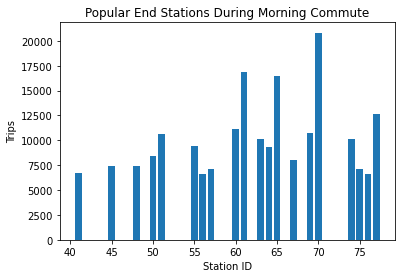

In [178]:
# plot popular end stations

plt.bar(pop_end_stations_df["ID"], pop_end_stations_df["Trips"])
plt.xlabel("Station ID")
plt.ylabel("Trips")
plt.title("Popular End Stations During Morning Commute")

The popular end stations in the morning are the same as the popular start stations during the evening, which makes sense given that those who commute one-way in the morning likely take the same (reversed) route home. As these are popular commute stations both ways, we will use them and our knowledge of average commuting duration to find the weekend commuters who use popular stations.

### Popular Station Weekend Commuters

In [176]:
%%bigquery pop_station_commuters_df

SELECT
    EXTRACT(DAYOFWEEK FROM end_date) AS Day,
    COUNT(trip_id) AS Trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE end_station_id IN(60, 61, 65, 70, 77) AND (duration_sec / 60) <= 20 AND (duration_sec / 60) >= 5 AND EXTRACT(DAYOFWEEK FROM end_date) IN(1, 7)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.27rows/s]


## 5) 5-20 Minute Weekend (Sat-Sun) Trips During Most Popular Hours

In [195]:
%%bigquery pop_weekend_trip_times_df

SELECT 
    EXTRACT(HOUR FROM start_date) AS Hour,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE (duration_sec / 60) <= 20 AND (duration_sec / 60) >= 5)
WHERE Day IN(1, 7)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 24/24 [00:01<00:00, 18.97rows/s]


Text(0.5, 1.0, 'Sat-Sun Commuting')

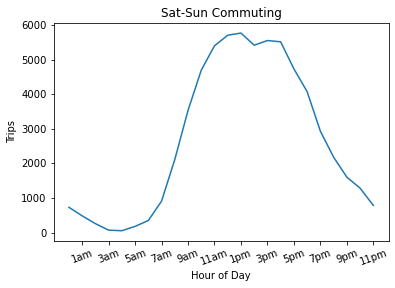

In [196]:
# plot popular weekend trip times between 5-20 mins

plt.plot(pop_weekend_trip_times_df["Hour"], pop_weekend_trip_times_df["Trips"])
plt.xlabel("Hour of Day")
plt.ylabel("Trips")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], ["1am", "3am","5am", "7am", "9am", "11am", "1pm", "3pm","5pm", "7pm", "9pm", "11pm"], rotation=20)
plt.title("Sat-Sun Commuting")

The most popular hours for trips on the weekends that are within our 5-20 minute range are centered around 1pm (10am-5pm). We can't completely discern the difference between commuter and recreational trips here, but our average commute time metric does provide us with some confidence. 

### Weekend Commutes During Popular Hours

In [197]:
%%bigquery weekend_time_commutes_df

SELECT 
    Hour,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(1, 7) AND Hour IN(10, 11, 12, 13, 14, 15, 16)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.54rows/s]


# What are your recommendations for offers (justify based on your findings)?

## 1) Offer better rates during "off hours"

In [207]:
%%bigquery subscriptions_commute_df

SELECT 
    Subscription,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        subscriber_type AS Subscription,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        trip_id,
    
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(2, 3, 4, 5, 6) AND Hour IN(7, 8, 9, 16, 17, 18)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.60rows/s]


In [209]:
%%bigquery subscriptions_offhours_df

SELECT 
    Subscription,
    COUNT(trip_id) AS Trips
FROM(
    SELECT
        start_date,
        subscriber_type AS Subscription,
        EXTRACT(DAYOFWEEK FROM start_date) AS Day,
        EXTRACT(HOUR FROM start_date) AS Hour,
        trip_id,
    
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day IN(2, 3, 4, 5, 6) AND Hour NOT IN(7, 8, 9, 16, 17, 18)
GROUP BY 1
ORDER BY 1 ASC

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.60rows/s]


Text(0.5, 1.0, 'Weekday Off Hours Trips by Subscription')

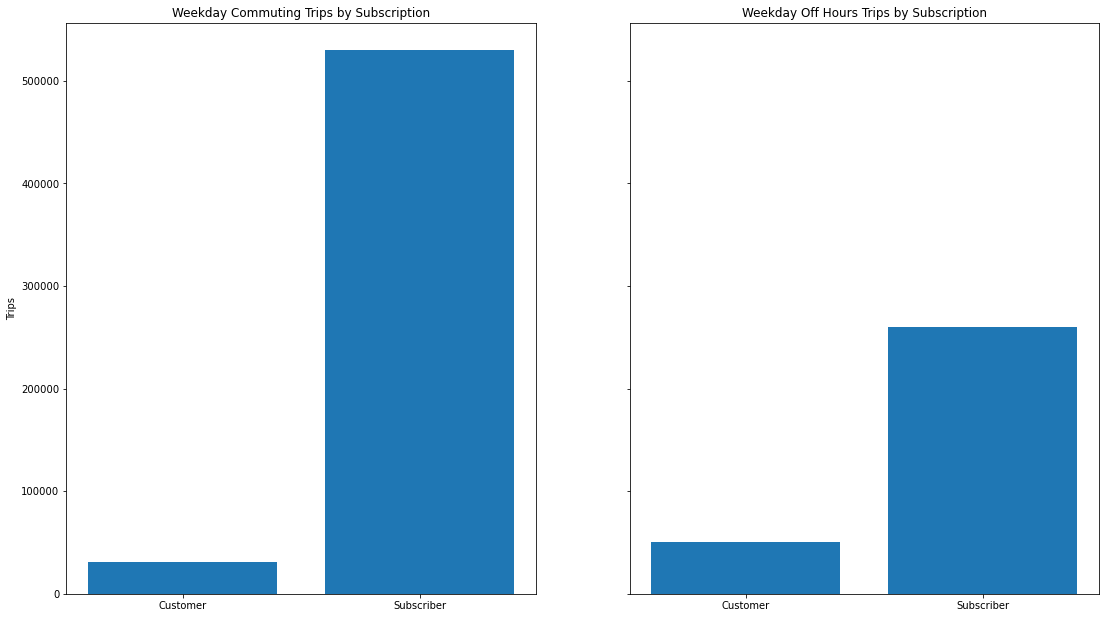

In [219]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(18.5, 10.5)

# plot trips by subscription type during weekday commuting hours
ax[0].bar(subscriptions_commute_df["Subscription"], subscriptions_commute_df["Trips"])
ax[0].set_ylabel("Trips")
ax[0].set_title("Weekday Commuting Trips by Subscription")

# plot trips by subscription type during weekday non-commuting hours
ax[1].bar(subscriptions_offhours_df["Subscription"], subscriptions_offhours_df["Trips"])
ax[1].set_title("Weekday Off Hours Trips by Subscription")

During the weekday commuting hours subscribers make up almost 95% of all trips, but during weekday "off hours", subscribers only make up about 84% of all trips. If we were to offer discounted rates to new subscribers during off hours, we could likely increase the number of trips during off hours generating more revenue and potentially addressing some of the supply difficulties during the peak hours, by allowing those with more flexible commute times a cheaper alternative.

## 2) Offer discounts on bikes at stations with high-availability during high-volume hours

In [ ]:
### Dockcount for Popular & NonPopular Stations

In [223]:
%%bigquery
SELECT
    station_id, 
    dockcount
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE station_id IN(60, 61, 65, 70, 77)
ORDER BY 2 DESC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.03rows/s]


,station_id,dockcount
0,61,27
1,77,27
2,70,19
3,60,15
4,65,15


In [224]:
%%bigquery
SELECT
    station_id, 
    dockcount
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE station_id NOT IN(60, 61, 65, 70, 77)
ORDER BY 2 DESC

Downloading: 100%|██████████| 69/69 [00:11<00:00,  6.15rows/s]


,station_id,dockcount
0,91,35
1,90,31
2,2,27
3,67,27
4,22,25
...,...,...
64,83,15
65,4,11
66,37,11
67,35,11


The dockcounts for both the popular and nonpopular stations are fairly similar meaning there shouldn't be a concern having people commute to these popular stations so long as there are bikes available.

### Avg. Bikes Per Station During Peak Hours For Not Popular Stations

In [215]:
%%bigquery

SELECT 
    station_id, 
    AVG(bikes_available) AS Avg_Bikes_Available
FROM(
    SELECT
        station_id, 
        bikes_available,
        EXTRACT(HOUR FROM time) AS Hour 
    FROM `bigquery-public-data.san_francisco.bikeshare_status`
    WHERE EXTRACT(DAY FROM time) IN(2, 3, 4, 5, 6) AND EXTRACT(HOUR FROM time) IN(7, 8, 9, 16, 17, 18) AND station_id NOT IN(60, 61, 65, 70, 77))
GROUP BY 1
ORDER BY 2 DESC

Downloading: 100%|██████████| 65/65 [00:00<00:00, 73.66rows/s] 


,station_id,Avg_Bikes_Available
0,2,13.199436
1,50,12.625231
2,22,11.758222
3,28,11.745697
4,69,11.592952
...,...,...
60,82,5.720471
61,45,5.714668
62,4,5.370663
63,37,5.232234


### Avg. Bikes Per Station During Peak Hours For Popular Stations

In [216]:
%%bigquery

SELECT 
    station_id, 
    AVG(bikes_available) AS Avg_Bikes_Available
FROM(
    SELECT
        station_id, 
        bikes_available,
        EXTRACT(HOUR FROM time) AS Hour 
    FROM `bigquery-public-data.san_francisco.bikeshare_status`
    WHERE EXTRACT(DAY FROM time) IN(2, 3, 4, 5, 6) AND EXTRACT(HOUR FROM time) IN(7, 8, 9, 16, 17, 18) AND station_id IN(60, 61, 65, 70, 77))
GROUP BY 1
ORDER BY 2 DESC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.63rows/s]


,station_id,Avg_Bikes_Available
0,77,12.983147
1,61,11.801911
2,70,9.802694
3,65,6.839330
4,60,6.692960


While there are still bikes avaialble on average during the busy hours, the amount of trips could lead to no bikes being available upsetting commuters. In order to ensure we provide a reliable service, it makes sense to divert some of these commuters to other stations with availability by provding incentives such as discounted rides for less popular stations nearby the popular stations. 